# An Analysis of Red Hot Chili Pepper’s Lyrics Using NLP

This notebook documents my end-to-end steps of collecting, visualizing and analyzing lyrics of Red Hot Chili Peppers's songs. 

I scrap the lyrics of all 12 studio albums from *azlyrics.com* and apply TF-IDF and LDA algorithms to generate meaningful insights about the albums and individual songs.

The results showed that both TF-IDF and LDA failed to generate meaningful topics.

## Collecting Data

In [1]:
from bs4 import BeautifulSoup
import requests
import re
import os

In [ ]:
rhcp_url = 'https://www.azlyrics.com/r/redhotchilipeppers.html'

r = requests.get(rhcp_url)
soup_album = BeautifulSoup(r.text, 'html.parser')
for cls in soup_album.find_all(class_=re.compile("(album)|(listalbum-item)")):
    if cls.get_text() == 'other songs:':
        break
    if cls['class'][0] == 'album':
        album = re.sub('(^.*: )|"', "", cls.text)
        try:
            os.mkdir(album)
        except:
            pass
    else:
        # check if song is downloaded already
        if os.path.exists(os.path.join(album, cls.a.get_text() + '.txt')):
            continue
        song_url ='https://www.azlyrics.com' + cls.a['href'][2:]
        r = requests.get(song_url)
        soup_song = BeautifulSoup(r.text, 'html.parser')
        title = soup_song.find('div', class_="ringtone").find_next('b').get_text().replace('"', "").replace("?", "").replace("/", "")
        lyrics = soup_song.find('div', class_="ringtone").find_next('div').get_text()
        print(title)
        with open(os.path.join(album, title + '.txt'), 'a+', encoding="utf-8") as f:
            f.write(title)
            f.write(lyrics)

In [2]:
# sort albums by year
albums = sorted([d for d in os.listdir(os.curdir) if os.path.isdir(d) and d.endswith(')')], 
                key=lambda x: re.search("(\d{4})", x).group(0))
albums

['The Red Hot Chili Peppers (1984)',
 'Freaky Styley (1985)',
 'The Uplift Mofo Party Plan (1987)',
 "Mother's Milk (1989)",
 'Blood Sugar Sex Magik (1991)',
 'One Hot Minute (1995)',
 'Californication (1999)',
 'By The Way (2002)',
 'Stadium Arcadium (2006)',
 "I'm With You (2011)",
 "I'm With You Sessions (2013)",
 'The Getaway (2016)']

In [3]:
lyrics_per_album = []
for album in albums:
    txts = os.listdir(album)
    album_lyrics = []
    for txt in txts:
        with open(os.path.join(album, txt)) as f:
            album_lyrics.append(f.read())
    lyrics_per_album.append(album_lyrics)

In [4]:
lyrics_per_album[5][7]

'My Friends\n\n\nMy friends are so depressed\nI feel the question of your loneliness\nConfide \'cause I\'ll be on your side\nYou know I will, you know I will\n\nEx-girlfriend called me up\nAlone and desperate on the prison phone\nThey want to give her 7 years\nFor being sad\n\n[Chorus:]\nI love all of you\nHurt by the cold\nSo hard and lonely, too\nWhen you don\'t know yourself\n\nMy friends are so distressed\nAnd standing on the brink of emptiness\nNo words I know of to express\nThis emptiness\n\n[Chorus]\n\nImagine me\nTaught by tragedy\nRelease\nIs peace\n\nI heard a little girl\nAnd what she said was something beautiful\n"To give your love no matter what."\nIs what she said.\n\n[Chorus]\n'

## Data Preprocessing

For this analysis common text preprocessing techniques were applied:
1. Removed punctuation;
2. Converted to lower case;
3. Removed English stop-words; 
4. Lemmatization.

Lemmatization was chosen over stemming in order to preserve the meaning of the words so they can be examined later. 

In [5]:
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords, wordnet
import nltk

wordnet_map = {
    "N": wordnet.NOUN,
    "V": wordnet.VERB,
    "J": wordnet.ADJ,
    "R": wordnet.ADV
}

def preprocess(text):
    # remove labels
    text = re.sub("\[[\w\s:]+\]", "", text)
    # step 1
    words = [word.lower() for word in word_tokenize(text) if word.isalpha()]
    #step 2
    words = [word for word in words if not word in stopwords.words('english')]
    #step 3
    lem = WordNetLemmatizer()
    words = [lem.lemmatize(word, wordnet_map.get(nltk.pos_tag([word])[0][1][0], wordnet.NOUN)) for word in words]
    return words 

## Counting Unique Words Per Album

A theory suggests that Stadium Arcadium is the most lyrically-sophisticated album. To check this theory, we are going to use ***the number of unique words*** as a metric for sophistication.

In [7]:
from collections import Counter

corpus = []
for album in lyrics_per_album:
    album_corpus = []
    for song in album:
        album_corpus += preprocess(song)
    corpus.append(Counter(album_corpus))

In [8]:
import pandas as pd

RHCP = pd.DataFrame(index=albums, columns=['Unique words'])
for a,l in zip(albums, corpus):
    RHCP.loc[a, 'Unique words'] = len(l)
RHCP

,Unique words
The Red Hot Chili Peppers (1984),607
Freaky Styley (1985),589
The Uplift Mofo Party Plan (1987),677
Mother's Milk (1989),632
Blood Sugar Sex Magik (1991),943
One Hot Minute (1995),819
Californication (1999),804
By The Way (2002),755
Stadium Arcadium (2006),1196
I'm With You (2011),628


In [9]:
# unique words / total words
for a,l in zip(albums, corpus):
    RHCP.loc[a, 'Total words'] = sum(l.values())
    #print("{}: {:.2f} unique / total".format(a, len(l)/sum(l.values())))
RHCP['Unique/Total'] = RHCP.iloc[:,0] / RHCP.iloc[:,1]
RHCP

,Unique words,Total words,Unique/Total
The Red Hot Chili Peppers (1984),607,1908.0,0.318134
Freaky Styley (1985),589,1272.0,0.46305
The Uplift Mofo Party Plan (1987),677,1758.0,0.385097
Mother's Milk (1989),632,1565.0,0.403834
Blood Sugar Sex Magik (1991),943,2444.0,0.385843
One Hot Minute (1995),819,1761.0,0.465077
Californication (1999),804,2413.0,0.333195
By The Way (2002),755,2353.0,0.320867
Stadium Arcadium (2006),1196,3794.0,0.315235
I'm With You (2011),628,2114.0,0.297067


<Figure size 432x288 with 0 Axes>

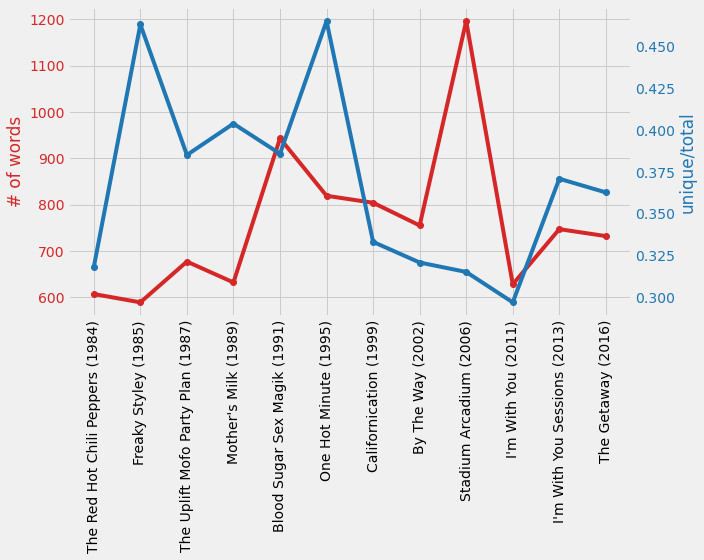

<Figure size 432x288 with 0 Axes>

In [10]:
# here is how it looks visually
# we can see that SA is not the most sofisticated album, at least when measured by the proportion of unique words
# it's interesting how thios proportion had been going down since Californation to I'm with you albums - arguably,
# one of the best albums of the modern peppers' era
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
plt.figure()
fig, ax1 = plt.subplots(figsize=(10,8))

color = 'tab:red'
ax1.set_ylabel('# of words', color=color)
ax1.plot(RHCP.index, RHCP.loc[:, 'Unique words'].values, color=color, marker='o')
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('unique/total', color=color)  # we already handled the x-label with ax1
ax2.plot(RHCP.index, RHCP.loc[:, 'Unique/Total'].values, color=color, marker='o')
ax2.tick_params(axis='y', labelcolor=color)
ax2.grid(b=None)
plt.draw()
ax1.set_xticklabels(ax1.get_xticklabels(), rotation = 90)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
#plt.show()
#fig.subplots_adjust(bottom=0.5)
plt.show()
plt.clf()

**Observations.**
- Stadium Arcadium is the most sophisticated album when measured by the **total unique words**.
- However, when weighted by the **total words**, Freaky Styley and One Hot Minute score the highest.
- The downward trend of **unique/total words** indicates that the level of sophistication had been falling since One Hot Minute.

## Most Used Words

A theory suggests that RHCP often sing about California, especially in their Californication album. Words that used the most per given album might help outline an overal topic of that album.

In [11]:
#most_used = pd.DataFrame(columns=['word #1', 'word #2', 'word #3', 'word #4', 'word #5'], index=albums)
for a,l in zip(albums, corpus):
    wds = [w[0] for w in l.most_common(5)]
    RHCP.loc[a, 'word #1'] = wds[0]
    RHCP.loc[a, 'word #2'] = wds[1]
    RHCP.loc[a, 'word #3'] = wds[2]
    RHCP.loc[a, 'word #4'] = wds[3]
    RHCP.loc[a, 'word #5'] = wds[4]
RHCP[['word #1', 'word #2', 'word #3', 'word #4', 'word #5']]

,word #1,word #2,word #3,word #4,word #5
The Red Hot Chili Peppers (1984),know,get,jump,well,men
Freaky Styley (1985),get,take,millionaire,make,love
The Uplift Mofo Party Plan (1987),party,want,love,pussy,get
Mother's Milk (1989),get,please,fire,make,come
Blood Sugar Sex Magik (1991),get,love,give,good,little
One Hot Minute (1995),get,love,one,like,could
Californication (1999),get,dance,phfat,come,know
By The Way (2002),get,know,want,make,come
Stadium Arcadium (2006),get,oh,come,make,na
I'm With You (2011),get,around,know,say,dance


**Observations:**
- Raw word counts elevate a lot of uninformative words
- Words from individual songs, rather than albums, dominate the counts. For example, *party, want, pussy* are from the same song - *Special Secret Song Inside*.

## Solution 1: TF-IDF
**Rationale**: TF-IDF penalizes frequently occuring words in all documents.

Each album is treated as a separate document.

In [12]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_corpus = []
for album in lyrics_per_album:
    album_corpus = ""
    for song in album:
        album_corpus = album_corpus + " " + " ".join(preprocess(song))
    tfidf_corpus.append(album_corpus)

In [13]:
tfidf = TfidfVectorizer(preprocessor=None, stop_words=None)
X = tfidf.fit_transform(tfidf_corpus)

In [14]:
X.A.shape

(12, 4007)

In [16]:
vocab = {v: k for k, v in tfidf.vocabulary_.items()}
vocab = sorted(vocab.items(), key=lambda x: x[1])
vocab_df = pd.DataFrame(X.A, columns=[c[1] for c in vocab], index=albums)
vocab_df.head()

,aaw,abandonment,abdul,abel,ability,ablaze,abnormality,aboard,aborigine,abortion,...,young,zanniest,zap,zen,zephyr,zeppelin,zodiac,zone,zoo,zulu
The Red Hot Chili Peppers (1984),0.026868,0.0,0.00000,0.0,0.000000,0.013434,0.0,0.000000,0.0,0.000000,...,0.005905,0.000000,0.000000,0.0,0.0,0.0,0.0,0.00000,0.0,0.000000
Freaky Styley (1985),0.000000,0.0,0.00000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,...,0.000000,0.000000,0.020096,0.0,0.0,0.0,0.0,0.00000,0.0,0.000000
The Uplift Mofo Party Plan (1987),0.000000,0.0,0.00000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,...,0.017269,0.013096,0.000000,0.0,0.0,0.0,0.0,0.00000,0.0,0.013096
Mother's Milk (1989),0.000000,0.0,0.02024,0.0,0.000000,0.000000,0.0,0.052147,0.0,0.000000,...,0.008897,0.000000,0.000000,0.0,0.0,0.0,0.0,0.03071,0.0,0.000000
Blood Sugar Sex Magik (1991),0.000000,0.0,0.00000,0.0,0.013786,0.000000,0.0,0.000000,0.0,0.013786,...,0.030300,0.000000,0.000000,0.0,0.0,0.0,0.0,0.00000,0.0,0.000000


In [17]:
for i,a in enumerate(albums):
    largest = vocab_df.iloc[i].nlargest(5)
    RHCP.loc[a, 'tfidf:word #1'] = largest.index[0]
    RHCP.loc[a, 'tfidf:word #2'] = largest.index[1]
    RHCP.loc[a, 'tfidf:word #3'] = largest.index[2]
    RHCP.loc[a, 'tfidf:word #4'] = largest.index[3]
    RHCP.loc[a, 'tfidf:word #5'] = largest.index[4]
RHCP.iloc[:,3:]

,word #1,word #2,word #3,word #4,word #5,tfidf:word #1,tfidf:word #2,tfidf:word #3,tfidf:word #4,tfidf:word #5
The Red Hot Chili Peppers (1984),know,get,jump,well,men,jump,coyote,hill,know,men
Freaky Styley (1985),get,take,millionaire,make,love,millionaire,turtle,nevermind,get,cup
The Uplift Mofo Party Plan (1987),party,want,love,pussy,get,party,pussy,want,love,get
Mother's Milk (1989),get,please,fire,make,come,please,yea,get,fire,funky
Blood Sugar Sex Magik (1991),get,love,give,good,little,get,sale,love,give,psycho
One Hot Minute (1995),get,love,one,like,could,aeroplane,bob,get,spike,love
Californication (1999),get,dance,phfat,come,know,phfat,get,dance,californication,view
By The Way (2002),get,know,want,make,come,cabron,get,know,want,make
Stadium Arcadium (2006),get,oh,come,make,na,get,bump,readymade,oh,torture
I'm With You (2011),get,around,know,say,dance,get,around,know,dance,say


**Observations:**
- TF-IDF did a better job of extracting less frequent words: the word *californication* finally appeared in Californication album.
- A better song representation was achieved comapred to raw counts: the algorithm picked up on at least 3 different songs in Stadium Arcadium: *Hump de Bump*, *Readymade*, and *Torture Me*. 
- Still, TF-IDF failed to pick up on an overrarching theme of each album.

## Solution 2: LDA

**Rationale:** LDA is the most common topic modeling technique. However, LDA requires large (>20k) collections of documents to correctly model the underlying distributions. 12 topics will be used as a hyperparameter as a naive assumption that LDA will correctly learn 12 albums.

In [18]:
# LDA needs more than 12 docs
# see paper http://proceedings.mlr.press/v32/tang14.pdf
from gensim.corpora.dictionary import Dictionary
import gensim

lda_corpus = []
for album in lyrics_per_album:
    for song in album:
        lda_corpus.append(preprocess(song))

Sometimes it is useful to generate various n-grams for LDA. "New_York" makes more sense rather than "New" and "York".

In [19]:
bigram = gensim.models.Phrases(lda_corpus, min_count=5, threshold=100)
trigram = gensim.models.Phrases(bigram[lda_corpus], min_count=5, threshold=100)
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)
lda_corpus = [trigram_mod[bigram_mod[doc]] for doc in lda_corpus]

dictionary = Dictionary(lda_corpus)
bow_corpus = [dictionary.doc2bow(text) for text in lda_corpus]

In [20]:
from gensim.models.ldamulticore import LdaMulticore
from gensim.models import CoherenceModel

model = LdaMulticore(bow_corpus, num_topics=12, id2word=dictionary, workers=7, passes=10, per_word_topics=True,
                        random_state=1)
coherence_model = CoherenceModel(model=model, corpus=bow_corpus, texts=lda_corpus, coherence='c_v')
print(coherence_model.get_coherence())
#plt.plot(range(2,20), coherence)

0.3038470971755345


In [21]:
from pprint import pprint

pprint(model.print_topics())
doc_lda = model[bow_corpus]

[(0,
  '0.029*"love" + 0.024*"get" + 0.021*"like" + 0.016*"come" + 0.015*"take" + '
  '0.010*"could" + 0.009*"phfat_dance" + 0.008*"life" + 0.008*"give" + '
  '0.008*"back"'),
 (1,
  '0.037*"away" + 0.020*"never" + 0.013*"get" + 0.011*"say" + 0.011*"see" + '
  '0.010*"hey" + 0.010*"one" + 0.010*"millionaire" + 0.009*"like" + '
  '0.009*"far"'),
 (2,
  '0.026*"get" + 0.014*"want" + 0.012*"say" + 0.011*"make" + 0.011*"know" + '
  '0.009*"like" + 0.009*"come" + 0.009*"go" + 0.009*"love" + 0.009*"around"'),
 (3,
  '0.031*"love" + 0.014*"come" + 0.013*"yeah" + 0.010*"mind" + '
  '0.010*"brother_cup" + 0.009*"talk" + 0.009*"get" + 0.009*"give" + '
  '0.008*"go" + 0.008*"like"'),
 (4,
  '0.028*"oh" + 0.024*"know" + 0.024*"yeah" + 0.019*"say" + 0.018*"hey" + '
  '0.016*"go" + 0.015*"like" + 0.015*"time" + 0.015*"get" + 0.011*"love"'),
 (5,
  '0.020*"make" + 0.015*"love" + 0.011*"girl" + 0.010*"like" + 0.010*"one" + '
  '0.009*"good" + 0.009*"know" + 0.008*"man" + 0.007*"time" + 0.007*"could"')

**Observations:**
- LDA failed to separate albums based on overrarching topics; rather it separated them based on dominant songs again.

In [23]:
# hyperparam tuning
from skopt.space import Real, Integer, Categorical
from skopt.utils import use_named_args
from skopt import gp_minimize

space = [
    Integer(3, 20, name="num_topics"),
    Real(0.01, 1, name='alpha'),
    Real(0.01, 1, name='eta'),
]

@use_named_args(space)
def objective(**params):
    model = LdaMulticore(bow_corpus, id2word=dictionary, workers=7, passes=30, per_word_topics=True,
                        random_state=1,
                        num_topics=params['num_topics'],
                        alpha=params['alpha'],
                        eta=params['eta'])
    coherence_model = CoherenceModel(model=model, corpus=bow_corpus, texts=lda_corpus, coherence='c_v')
    return -coherence_model.get_coherence()

res_gp = gp_minimize(objective, space, n_calls=15, n_jobs=-1, verbose=False)

In [24]:
print("Best coherence: {:.2f}".format(res_gp.fun))
print("Best parameters: {}, {:.2f}, {:.2f}".format(res_gp.x[0], res_gp.x[1], res_gp.x[2]))

Best coherence: -0.58
Best parameters: 20, 1.00, 1.00


In [25]:
# train the model based on these parameters and visualize the results
model = LdaMulticore(bow_corpus, id2word=dictionary, workers=7, passes=30, per_word_topics=True,
                        num_topics=20,
                        alpha=1,
                        eta=1,random_state=1)

In [26]:
coherence_model = CoherenceModel(model=model, corpus=bow_corpus, texts=lda_corpus, coherence='c_v')
coherence_model.get_coherence()

0.5814764285537424

[t-SNE] Computing 193 nearest neighbors...
[t-SNE] Indexed 194 samples in 0.000s...
[t-SNE] Computed neighbors for 194 samples in 0.003s...
[t-SNE] Computed conditional probabilities for sample 194 / 194
[t-SNE] Mean sigma: 0.071014
[t-SNE] KL divergence after 250 iterations with early exaggeration: 46.541264
[t-SNE] KL divergence after 1000 iterations: 0.042781


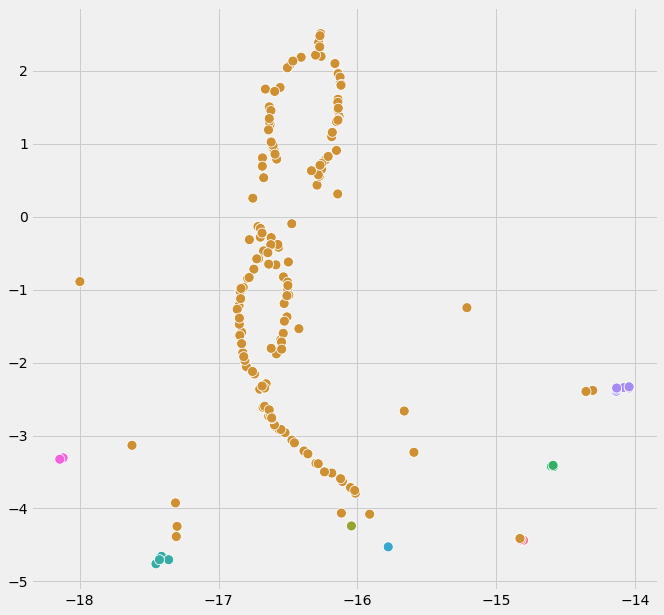

In [27]:
from sklearn.manifold import TSNE
import numpy as np
from matplotlib import colors as mcolors
import matplotlib

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

# Get topic weights
arr = pd.DataFrame(columns=[el for el in range(16)], index=range(len(model[bow_corpus])))

topic_weights = []
for i, row in enumerate(model[bow_corpus]):
    for pair in row[0]:
        arr.loc[i, pair[0]] = pair[1]
        
# Array of topic weights    
arr = arr.fillna(0).values

# Keep the well separated points (optional)
arr = arr[np.amax(arr, axis=1) > 0.35]

# Dominant topic number in each doc
topic_num = np.argmax(arr, axis=1)

# tSNE Dimension Reduction
tsne_model = TSNE(n_components=2, verbose=1, random_state=0, init='pca', perplexity=100)
tsne_lda = tsne_model.fit_transform(arr)

scat = pd.DataFrame(data=tsne_lda, columns=['x', 'y'])
scat['color'] = topic_num
scat['color'] = scat['color'].astype('category')

# Plot the Topic Clusters using Bokeh
n_topics = 16
mycolors = np.array([matplotlib.cm.rainbow(i) for i in range(n_topics)])
fig, ax = plt.subplots(figsize=(10,10))
ax = sns.scatterplot(data=scat, x='x', y='y', hue='color', legend=None, s=100)
#ax.set_yticklabels([])
#ax.set_xticklabels([])
ax.set(xlabel='', ylabel='')
plt.show()
plt.clf()

c:\users\miros\appdata\local\programs\python\python38\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


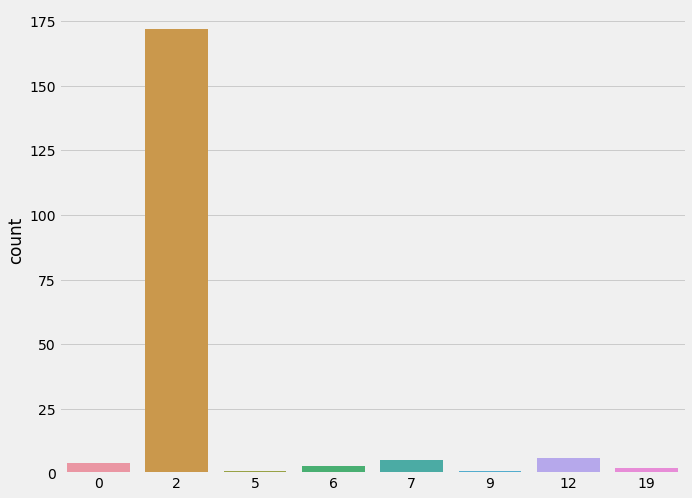

<Figure size 432x288 with 0 Axes>

In [29]:
scat.rename(columns={'color' : 'category'}, inplace=True)
fig, ax = plt.subplots(figsize=(10,8))
ax = sns.countplot(scat['category'])
ax.set(xlabel='')
plt.show()
plt.clf()

**Observations:**
- RHCP songs cannot be modeled equally after after the corresponding albums.
- Category 2 dominates the rest of them.

In [30]:
from pprint import pprint
pprint(model.print_topics()[2])

(2,
 '0.024*"get" + 0.015*"know" + 0.014*"love" + 0.012*"like" + 0.011*"come" + '
 '0.010*"make" + 0.010*"say" + 0.009*"go" + 0.008*"want" + 0.008*"time"')


- Topic 2 is not informative enough to establish a theme.

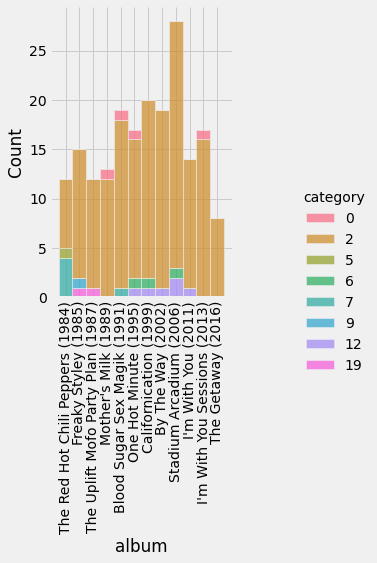

In [31]:
# topic distribution by album
scat.loc[:12,'album'] = 'The Red Hot Chili Peppers (1984)'
i = 0
prev = 0
for idx, album in enumerate(lyrics_per_album):
    i +=len(album)
    scat.loc[prev:i,'album'] = albums[idx]
    prev = i

#fig, ax = plt.subplots(figsize=(10,8))    
ax = sns.displot(scat, x='album', hue='category', multiple='stack')
#plt.draw()
ax.set_xticklabels(ax1.get_xticklabels(), rotation = 90)

fig.tight_layout()
plt.show()

**Observations:**
- Earlier albums seem to have more topics.
- However, it is not enough to make any conclusions.

## Bonus Theory: 

When Anthony Kiedis (vocalist) was writing "Dani California" (2006), he realized that it's actually a continuation of a story he started earlier in "Californication" (1999) and continued in "By The Way" (2002). To test this theory, we are going to plot the these 3 songs in proximity to each other on a TSNE plot.

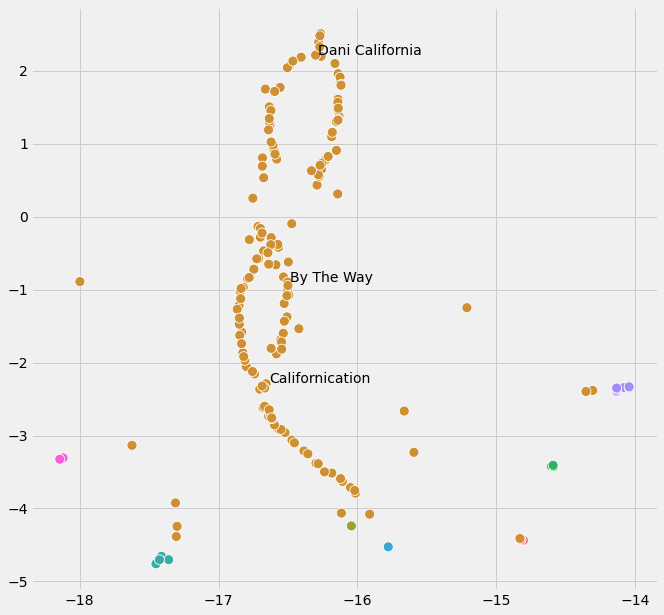

<Figure size 432x288 with 0 Axes>

In [32]:
# californication lda_corpus[89]
# by the way lda_corpus[109]
# dani california lda_corpus[131]

scat_new = scat.copy()
scat_new.loc[:, 'Label'] = "None"
scat_new.loc[89, 'Label'] = 'Californication'
scat_new.loc[109, 'Label'] = 'By The Way'
scat_new.loc[131, 'Label'] = 'Dani California'

fig, ax = plt.subplots(figsize=(10,10))
ax = sns.scatterplot(data=scat_new, x='x', y='y', hue='category', legend=None, s=100)
for row in scat_new.iterrows():
    if row[1]['Label'] != "None":
        ax.text(row[1]['x']+.02, row[1]['y'], str(row[1]['Label']))
ax.set(xlabel='', ylabel='')
plt.show()
plt.clf()

**Observations:**
- All 3 songs are far apart from each other, which suggests that lyrically they are not very similar.

## Conclusions
- The level of sophistication of RHCP's albums has been falling since One Hot Minute.
- Raw word count is bad representation of album's topic.
- TF-IDF and LDA fail the identify meaningful topics due to insufficient amount of data.
- Better algorithms for summarization and topic modeling are available which work better for smaller datasets.